# Analisi del grafo di Wikipedia Italia 2013
## Progetto finale di Algoritmi e Programmazione per Analisi Dati - A.A. 2023/2024
## Autore: Cristian Bargiacchi

Il progetto consiste nel rispondere a delle domande riguardanti metodi di analisi di grafi viste a lezione, ed è articolato in 3 punti principali. Di seguito importiamo le librerie che serviranno:

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from queue import Queue
from collections import defaultdict
from random import choice

Abbiamo due file: il primo, denominato "itwiki-2013.arcs" contiene una riga per ogni arco del nostro grafo. Il secondo, denominato "itwiki-2013.ids" contiene gli ID delle pagine di Wikipedia. La numerazione dei nodi segue gli indici delle righe (alla i-esima riga, numero i). Costruiamo un dizionario che associa i nomi delle pagine al corrispondente ID, ovvero l'indice di riga. Già che ci siamo costruiamo anche il dizionario inverso, che associa ad ogni ID la denominazione della pagina corrispondente (ci servirà in seguito).

In [2]:
path_ids = "Data/itwiki-2013.ids"
page_to_id = {}
id_to_page = {}
with open(path_ids, 'r', encoding='utf-8') as reader_1:
    for i, line in enumerate(reader_1):
        line = line.strip()
        page_to_id[line] = i
        id_to_page[i]=line

print(id_to_page.get(261576))
print(page_to_id.get("Città dell'India"))

Città dell'India
261576


A questo punto procediamo alla costruzione del grafo direzionato su Network X. Per farlo ci conviene prima trasformare il file csv degli archi in un oggetto "Data Frame" della libreria Pandas. Costruiamo anche una versione ridotta di 10.000 archi per usarlo come prova.

In [3]:
path_arcs = "Data/itwiki-2013.arcs"
arcs_df_prova = pd.read_csv(path_arcs,sep=" ", header=None, names=['v1','v2'])

A questo punto procediamo alla costruzione del grafo direzionato.

In [4]:
def create_graph(df:pd.DataFrame) -> nx.DiGraph:
    G = nx.DiGraph()
    
    for index, line in df.iterrows():
        v1 = int(line['v1'])
        v2 = int(line['v2'])
        G.add_edge(v1,v2)
        
    return G
g_prova = create_graph(arcs_df_prova)
print(g_prova)

DiGraph with 1016179 nodes and 25619926 edges


# Domanda 1: Calcola la distribuzione "out-degree" del grafo

Per rispondere alla prima domanda definiremo una funzione "outDegree_distribution". Essa costruirà un dizionario che associa ad ogni nodo la lista dei suoi vicini uscenti: il grado in uscita del nodo sarà la lunghezza di questa lista.
A questo punto sarebbe sufficiente associare a ogni grado le frequenze di nodi aventi quel valore. Tuttavia oltre alla frequenza associamo al grado anche la lista dei nodi con quel valore di out degree, per poterli utilizzare in seguito. 

In [5]:
def outDegree_distribution (g:nx.DiGraph) -> dict:
    neighbors_dict ={node: list(g.successors(node)) for node in g.nodes()} # da nodo a lista vicini
    distribution_dict = {} # da grado a array di 2 elementi: in posizione 0, nodi con quel grado; in posizione 1, conteggio nodi con quel grado
    for node in neighbors_dict.keys():
        degree_node = len(neighbors_dict[node])
        if degree_node in distribution_dict:
            distribution_dict[degree_node][0].append(node)
            distribution_dict[degree_node][1]+=1
        else:
            distribution_dict[degree_node] = [[node],1]
    return distribution_dict
g_outDegree = outDegree_distribution(g_prova)

Plottiamo la distribuzione delle frequenze degli out-degree:

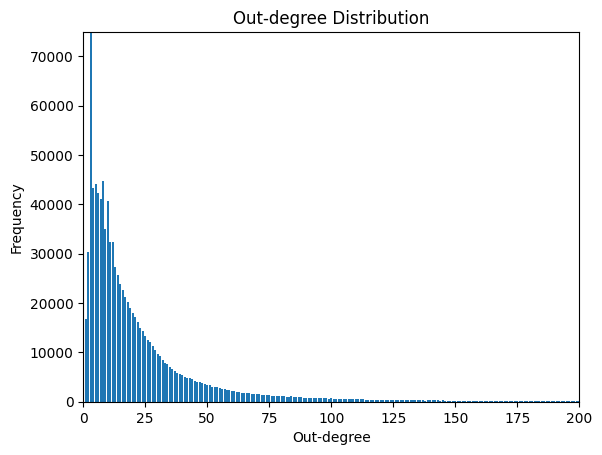

In [6]:
degrees = list(g_outDegree.keys())
frequencies = [g_outDegree[degree][1] for degree in degrees]

plt.bar(degrees, frequencies)
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.xlim([0,200])
plt.ylim([0,max(frequencies)])
plt.title('Out-degree Distribution')
plt.show()

## 1.1: Quali sono le 10 pagine di Wikipedia con maggior numero di link verso altre pagine?

Per trovare i 10 nodi con grado in uscita maggiore, aggiungiamo tutti i nodi con grado massimo a una lista finchè questa non arriva a lunghezza 10. Partiamo dal grado massimo e ad ogni aggiunta decrementiamo di 1. Abbiamo scelto questa strada in quanto l'ordinamento dei nodi per grado decrescente sarebbe stato leggermente più costoso a livello computazionale rispetto a calcolarne il massimo 10 volte. 

In [7]:
max_degree = max(degrees)
top_10 = list()

while len(top_10)<10:
    if max_degree in g_outDegree.keys():
        nodes = list(g_outDegree[max_degree][0])
        top_10.extend(nodes)
    max_degree = max_degree - 1
top10 = top_10[:10]
top10_pages = []
for id in top10:
    top10_pages.append(id_to_page[id])
top10_pages = pd.Series(top10_pages, index=range(1,11))
print(top10_pages)

1                  Città dell'India
2     Classificazione Nickel-Strunz
3                     Nati nel 1981
4                     Nati nel 1985
5                     Nati nel 1983
6                     Nati nel 1984
7                     Nati nel 1986
8                     Nati nel 1982
9                     Nati nel 1980
10                Nativi del Veneto
dtype: object


# Domanda 2: Sia U(G) la versione indiretta del grafo. Calcola il diametro della sua componente connessa più grande.

Per il calcolo del diametro utilizzeremo l'algoritmo "iFub" visto a lezione. Prima di tutto definisco una funzione per rendere il grafo indiretto e selezionare la componente connessa più grande.

In [8]:
def get_largest_cc_undirected(G:nx.DiGraph)->nx.Graph:
    G = nx.to_undirected(G)
    return G.subgraph(
    sorted(nx.connected_components(G), key = len, reverse=True)[0]
    ).copy()

LCC = get_largest_cc_undirected(g_prova)

Adesso facciamo una BFS dal nodo con grado maggiore della LCC, dopodichè in un dizionario associamo ogni nodo raggiunto alla distanza a cui si trova dal nodo di partenza. Ciò servirà per l'implementazione dell'algoritmo iFub e per recuperare le distanze in tempo costante, senza ricalcolarle ogni volta. La distanza massima sarà il nostro lower bound, mentre l'upper bound sarà il doppio.

In [9]:
def customBFS(LCC, startNode):
    visited = {}
    queue = Queue()
    queue.put(startNode)
    visited[startNode] = 0
    while not queue.empty():
        currentNode = queue.get()
        for nextNode in LCC.neighbors(currentNode):
            if nextNode not in visited:
                queue.put(nextNode)
                visited[nextNode]=visited[currentNode]+1
    B_u = defaultdict(list)
    for key, value in visited.items():
        B_u[value].append(key)
    return B_u

def computeDiameter(LCC, Bu):
    i = lb = max(Bu)
    ub = 2*lb
    while ub > lb:
        eccDict = nx.eccentricity(LCC, Bu[i])
        Bi = max(eccDict.values())
        maxVal = max(Bi,lb)
        if maxVal > 2*(i - 1):
            return print("diametro: ", maxVal)
        else: 
            lb = maxVal
            ub = 2*(i - 1) 
        i = i - 1 
    return print("Diametro iFub: ", lb)

startNode = max(LCC.degree,key=lambda x: x[1])[0]
B_u = customBFS(LCC, startNode)
computeDiameter(LCC,B_u)

Diametro iFub:  8


Ripetiamo il procedimento per il grafo in cui si escludono le pagine "disambigua".

In [11]:
def create_graph_without_disambigua(df:pd.DataFrame) -> nx.DiGraph:
    G = nx.DiGraph()
    
    for index, line in df.iterrows():
        v1 = int(line['v1'])
        v2 = int(line['v2'])
        
        if "disambigua" not in id_to_page[v1] and "disambigua" not in id_to_page[v2]:
            G.add_edge(v1,v2)
    return G

G_without_disambigua_prova = create_graph_without_disambigua(arcs_df_prova)

LCC_dis = get_largest_cc_undirected(G_without_disambigua_prova)
startNode_dis = max(LCC_dis.degree,key=lambda x: x[1])[0]
B_u_dis = customBFS(LCC_dis, startNode_dis)
computeDiameter(LCC_dis, B_u_dis)

Diametro iFub:  8


# Domanda 3: Trovare una clique massimale nel grafo indiretto U(g)
Clique: sottografo completo (ogni nodo è connesso ad ogni altro). Clique massimale: aggiungendo un altro nodo smetterebbe di essere una clique. L'algoritmo di Bron-Kerbosch parte da un insieme vuoto R e da un insieme di candidati P. Aggiungendo un nodo di P a R, la lista dei candidati diventa l'intersezione tra i precedenti elementi di P e i vicini del nodo aggiunto. Continuiamo finchè P non diventa vuoto. In X finiscono i nodi già visitati che non fanno parte di una clique di ordine maggiore o uguale a 3. 



In [16]:
U_g = nx.to_undirected(g_prova)

def Bron_Kerbosch(G, R, P, X):
    if not P and not X:
        return R
    for v in list(P):
        myclique = Bron_Kerbosch(
            G, 
            R.union({v}), 
            P.intersection(G.neighbors(v)),
            X.intersection(G.neighbors(v))
        )
        if myclique and len(myclique) >= 3:
            return myclique
        P.remove(v)
        X.add(v)
    return None 

def find_a_maximal_clique(G:nx.Graph()):
    nodes = list(G.nodes())
    for i in range(len(nodes)):
        start_node = choice(nodes)
        R = {start_node}
        P = set(G.neighbors(start_node))
        X = set()
        myclique = Bron_Kerbosch(G, R, P, X)
        if myclique and len(myclique) >= 3:            
            myclique_pages = set()
            for id in myclique:
                myclique_pages.add(id_to_page[id])
            return print("Una clique massimale di ordine 3 o superiore è: ", myclique_pages)
    return "Nessuna clique di ordine 3 trovata"
    
find_a_maximal_clique(U_g)

Una clique massimale di ordine 3 o superiore è:  {'Anders Sandøe Ørsted', 'Danimarca', 'Primi ministri della Danimarca'}


## 3.1: Se volessi trovarne 2?
Per trovare n clique massimali inserisco semplicemente una lista, in cui aggiunto tutte le clique che trovo. Devo aggiungere anche un controllo per verificare che la prossima clique non sia già stata inserita.

In [18]:
def find_n_maximal_cliques(G, n): 
    nodes = list(G.nodes())
    maximal_cliques = []
    iter = 0
    while len(maximal_cliques) < n:
        iter += 1
        start_node = choice(nodes)
        R = {start_node}
        P = set(G.neighbors(start_node))
        X = set()
        myclique = Bron_Kerbosch(G, R, P, X)
        if myclique and len(myclique) >= 3 and myclique :
            duplicate = False
            for old_clique in maximal_cliques:
                if myclique == old_clique:
                    duplicate = True
            if not duplicate:
                maximal_cliques.append(myclique)
                myclique_pages = set()
                for id in myclique:
                    myclique_pages.add(id_to_page[id])
                print("Clique massimale ", iter, ": ", myclique_pages)
    
    return maximal_cliques

find_n_maximal_cliques(U_g, 2)

Clique massimale  1 :  {'De Pontevès', 'Provenza-Alpi-Costa Azzurra', 'Pontevès'}
Clique massimale  2 :  {'Sporting Clube de Portugal', 'Kwame Ayew', 'Boavista Futebol Clube', 'Primeira Liga 1999-2000'}


[{434904, 828673, 870283}, {703808, 703969, 704000, 704049}]